In [32]:
import pandas as pd
import numpy as np
import os


In [33]:
pd.set_option('display.max_columns', None)

# Read datasets from the interim directory
X_train = pd.read_pickle("../../data/interim/X_train_binary.pkl")
X_val = pd.read_pickle("../../data/interim/X_val_binary.pkl")
X_test = pd.read_pickle("../../data/interim/X_test_binary.pkl")
y_train = pd.read_pickle("../../data/interim/y_train_binary.pkl")
y_val = pd.read_pickle("../../data/interim/y_val_binary.pkl")
y_test = pd.read_pickle("../../data/interim/y_test_binary.pkl")

In [34]:
'''
# collapse BSC, FKL, SDL, FOL into FALL
fall_labels = ['BSC', 'FKL', 'SDL', 'FOL']

y_train = y_train.apply(lambda x: x if x in fall_labels else 'ADL')
y_val = y_val.apply(lambda x: x if x in fall_labels else 'ADL')
y_test = y_test.apply(lambda x: x if x in fall_labels else 'ADL')

'''

"\n# collapse BSC, FKL, SDL, FOL into FALL\nfall_labels = ['BSC', 'FKL', 'SDL', 'FOL']\n\ny_train = y_train.apply(lambda x: x if x in fall_labels else 'ADL')\ny_val = y_val.apply(lambda x: x if x in fall_labels else 'ADL')\ny_test = y_test.apply(lambda x: x if x in fall_labels else 'ADL')\n\n"

In [35]:
y_train.unique()

array(['ADL', 'FALL'], dtype=object)

### Segment into Windows

In [36]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'azimuth','pitch','roll']

def create_windows(X, y, window_size=125, step_size=62): # 2.5 sec with 50% overlapping windows
    X_windows, y_windows = [], []
    
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data = X[start:end]
        window_labels = y[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X_windows.append(window_data)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)

In [37]:
X_train_windows, y_train_windows = create_windows(X_train, y_train)
X_val_windows, y_val_windows = create_windows(X_val, y_val)
X_test_windows, y_test_windows = create_windows(X_test, y_test)

In [38]:
X_train_windows.shape

(44862, 125, 9)

### Encode Label

In [39]:
label_map = {'ADL': 0, 'FALL': 1}
y_train_windows_encoded = np.vectorize(label_map.get)(y_train_windows)
y_val_windows_encoded = np.vectorize(label_map.get)(y_val_windows)
y_test_windows_encoded = np.vectorize(label_map.get)(y_test_windows)

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC


# Implementation of "LSTM-CNN Architecture for Human Activity Recognition" by Kun Xia et al. (IEEE Access, 2020)
# Adapted from https://github.com/quotation2520/CAGE4HAR/blob/main/models/LSTM_CNN.py

## X_train_windows.shape == (n_samples, 100, 6)
input_shape = (X_train_windows.shape[1], X_train_windows.shape[2]) 
num_classes = len(set(y_train_windows_encoded))                  

model_lstm_conv = Sequential([

    # ——— LSTM stack ———
    # first LSTM returns full sequence
    LSTM(32, return_sequences=True, input_shape=input_shape),
    # second LSTM also returns full sequence
    LSTM(32, return_sequences=True),

    # ——— 1D‐Conv + Pool ———
    Conv1D(
        filters=64,
        kernel_size=5,
        strides=2,
        activation='relu',
        padding='valid'   # matches PyTorch default
    ),
    MaxPooling1D(pool_size=2, strides=2),

    # ——— second Conv block ———
    Conv1D(
        filters=128,
        kernel_size=3,
        strides=1,
        activation='relu',
        padding='valid'
    ),

    # ——— batch‐norm & spatial collapse ———
    BatchNormalization(),            # normalise over feature‐axis
    GlobalAveragePooling1D(),        # mean over time dimension

    # ——— classification head ———
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output
])

model_lstm_conv.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model_lstm_conv.summary()

c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 125, 32)        │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 125, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 61, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 28, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,345 (192.75 KB)

 Trainable params: 49,089 (191.75 KB)

 Non-trainable params: 256 (1.00 KB)

In [46]:
from sklearn.utils import class_weight

In [47]:
# Compute class weights to handle imbalance
y_train_array = np.array(y_train_windows_encoded)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_array),
    y=y_train_array
)
class_weights = dict(enumerate(class_weights))


In [48]:
history = model_lstm_conv.fit(
    X_train_windows, y_train_windows_encoded,
    validation_data=(X_val_windows, y_val_windows_encoded),
    epochs=20,
    batch_size=64,
    class_weight=class_weights
)

Epoch 1/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - binary_accuracy: 0.7482 - loss: 0.4675 - val_binary_accuracy: 0.8986 - val_loss: 0.3929
Epoch 2/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - binary_accuracy: 0.9363 - loss: 0.2115 - val_binary_accuracy: 0.9544 - val_loss: 0.2534
Epoch 3/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - binary_accuracy: 0.9599 - loss: 0.1515 - val_binary_accuracy: 0.9010 - val_loss: 0.3804
Epoch 4/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - binary_accuracy: 0.9642 - loss: 0.1364 - val_binary_accuracy: 0.8711 - val_loss: 0.5262
Epoch 5/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - binary_accuracy: 0.9679 - loss: 0.1124 - val_binary_accuracy: 0.9366 - val_loss: 0.2636
Epoch 6/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - binary_accuracy: 0.9739 - loss: 0.0956 - val_binary_accuracy: 0.8912 - val_loss: 0.4603
Epoch 7/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - binary_accuracy: 0.9768 - loss: 0.0816 - val_binary_accuracy: 0.9428 - val_loss:

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.0810
Test Accuracy: 0.9782
452/452 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step


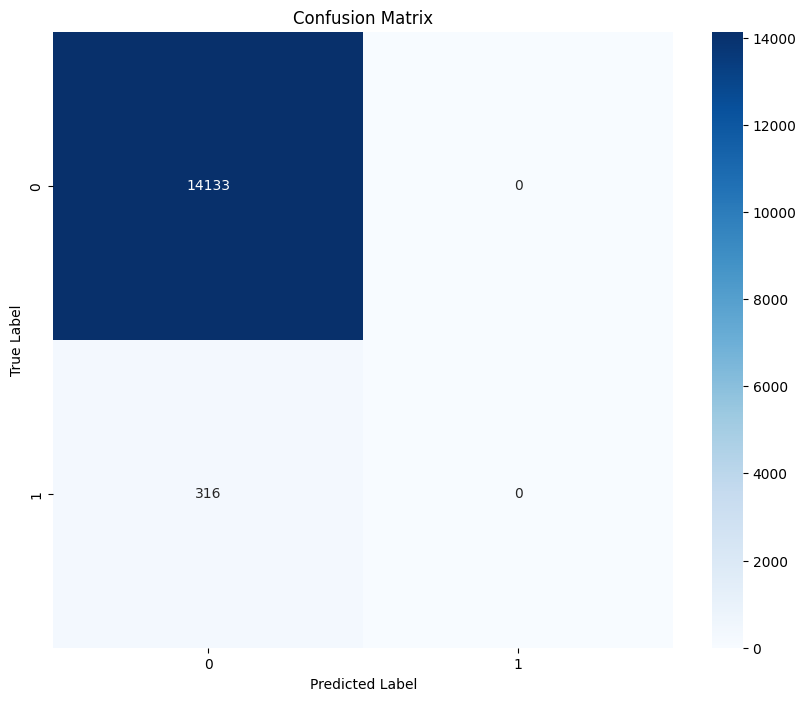

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14133
           1       0.00      0.00      0.00       316

    accuracy                           0.98     14449
   macro avg       0.49      0.50      0.49     14449
weighted avg       0.96      0.98      0.97     14449

Weighted Precision: 0.9567
Weighted Recall: 0.9781
Weighted F1 Score: 0.9673


c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

In [50]:
metrics = evaluate_model(model_lstm_conv, X_test_windows, y_test_windows_encoded)

### 10 - Fold Cross Validation

In [ ]:
from sklearn.model_selection import GroupKFold

In [ ]:
# Read datasets from the interim directory
df_filtered = pd.read_pickle("../../data/interim/df_filtered.pkl")

In [ ]:
from tensorflow.keras import Input

def build_model(input_shape, num_classes):
    model_cnn_lstm = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        # The LSTM layer now interprets the feature maps temporally.
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
])

    model_cnn_lstm.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
    return model_cnn_lstm

In [ ]:
sensor_cols = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']
groups     = df_filtered['subject_id'].values
gkf        = GroupKFold(n_splits=10)

val_losses     = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(
        gkf.split(df_filtered, df_filtered['label'], groups=groups)):

    # ----- 1) Select raw fold data -----
    df_tr = df_filtered.iloc[train_idx]
    df_va = df_filtered.iloc[val_idx]

    X_tr_raw = df_tr[sensor_cols].values
    y_tr_raw = df_tr['label'].values
    X_va_raw = df_va[sensor_cols].values
    y_va_raw = df_va['label'].values

    # ----- 2) Window -----
    X_train_windows, y_train_windows = create_windows(X_tr_raw, y_tr_raw,
                                                      window_size=50,
                                                      step_size=25)
    X_val_windows,   y_val_windows   = create_windows(X_va_raw, y_va_raw,
                                                      window_size=50,
                                                      step_size=25)

    # ----- 3) Encode labels -----
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_windows)
    y_val_encoded   = le.transform(y_val_windows)

    # ----- 4) Build model -----
    input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])  # (50,6)
    num_classes = len(le.classes_)

    model = build_model(input_shape, num_classes)

    # ----- 5) Train -----
    history = model.fit(
        X_train_windows, y_train_encoded,
        validation_data=(X_val_windows, y_val_encoded),
        epochs=25, batch_size=32, verbose=0
    )

    # ----- 6) Collect metrics -----
    val_loss = history.history['val_loss'][-1]
    val_acc  = history.history['val_accuracy'][-1]
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Fold {fold+1} — val_loss: {val_loss:.4f}, val_acc: {val_acc:.4%}")

# ----- 7) Aggregate across folds -----
mean_loss = np.mean(val_losses)
std_loss  = np.std(val_losses)
mean_acc  = np.mean(val_accuracies)
std_acc   = np.std(val_accuracies)

print("\n=== Cross‐Validation Results ===")
print(f"Val Loss: {mean_loss:.4f} ± {std_loss:.4f}")
print(f"Val Acc:  {mean_acc:.4%} ± {std_acc:.4%}")
